## Get data from PubMed

# DrugBank

In [29]:
import voyageai
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Use Voyage AI API KEY
api_key = os.getenv("VOYAGE_AI_API_KEY")

vo = voyageai.Client(api_key=api_key)
# This will automatically use the environment variable VOYAGE_API_KEY.
# Alternatively, you can use vo = voyageai.Client(api_key="<your secret key>")

result = vo.embed(["hello world"], model="voyage-large-2")

In [30]:
# Set a distinct number of drug categories
distinct_drug_categories = [
    'Analgesics',
    'Antibiotics',
    'Antifungal Agents',
    'Antiviral Agents',
    'Antipyretics',
    'Antiseptics',
    'Mood Stabilizers',
    'Anti-Inflammatory Agents',
    'Anticoagulants',
    'Antihistamines',
    'Diuretics',
    'Laxatives',
    'Bronchodilators',
    'Anticonvulsants',
    'Antidepressants'
]

In [31]:
def embed_vector(list_of_text):
    list_of_text: list
    if type(list_of_text) == list:
        result = vo.embed(list_of_text, model="voyage-large-2")
    else:
        print("The input must be a list")
        return TypeError
    return result.embeddings

def best_drug_category(categories, standard_list):
    vecs = embed_vector([categories]+standard_list)
    vec_array = np.array(vecs)

    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(vec_array)

    first_line_similarities = similarity_matrix[0, 1:]

    # Find the index of the highest similarity
    best_fit_index = np.argmax(first_line_similarities)

    # Get the corresponding category
    best_fit_category = distinct_drug_categories[best_fit_index]

    return best_fit_category

def plot_variance_distribution(data):
    plt.figure(figsize=(8, 6))
    sns.histplot(data, bins=20, kde=True)
    plt.title('Distribution of Variance Values (without self-similarity)')
    plt.xlabel('Variance')
    plt.ylabel('Frequency')
    plt.show()
    return True

In [33]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Base URL for DrugBank
base_url = "https://go.drugbank.com/drugs/"

# Range of DrugBank IDs to scrape
start_id = 1000
end_id = 2000  # Example range, adjust as needed

# Initialize a list to store drug data
drugs_data = []

for i in range(start_id, end_id + 1):
    drug_id = f"DB{i:05d}"
    url = f"{base_url}{drug_id}"
    response = requests.get(url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract the drug ID
        drug_id_meta = soup.find('meta', attrs={'name': 'dc.identifier'})
        drug_id_value = drug_id_meta['content'] if drug_id_meta else 'N/A'
        
        # Extract the drug name
        drug_name_meta = soup.find('meta', attrs={'name': 'dc.title'})
        drug_name = drug_name_meta['content'] if drug_name_meta else 'N/A'
        
        # Extract the drug description
        description_meta = soup.find('meta', attrs={'name': 'description'})
        description = description_meta['content'] if description_meta else 'N/A'
        
        # Extract additional fields by looking for dt/dd pairs
        def get_text_for_label(label):
            tag = soup.find('dt', text=label)
            if tag:
                next_tag = tag.find_next_sibling('dd')
                if next_tag:
                    return next_tag.text.strip()
            return 'N/A'

        # Data to collect
        mechanism_of_action = get_text_for_label('Mechanism of action')
        indication = get_text_for_label('Indication')
        pharmacodynamics = get_text_for_label('Pharmacodynamics')
        absorption = get_text_for_label('Absorption')
        volume_of_distribution = get_text_for_label('Volume of distribution')
        protein_binding = get_text_for_label('Protein binding')
        metabolism = get_text_for_label('Metabolism')
        drug_categories = get_text_for_label('Drug Categories')

        # Append the data to the list
        drugs_data.append({
            'DrugBank ID': drug_id_value,
            'Name': drug_name,
            'Description': description,
            'Mechanism of Action': mechanism_of_action,
            'Indication': indication,
            'Pharmacodynamics': pharmacodynamics,
            'Absorption': absorption,
            'Volume of Distribution': volume_of_distribution,
            'Protein Binding': protein_binding,
            'Metabolism': metabolism,
            'Drug Categories': drug_categories,
            # Add more fields as necessary
        })
        print(f"Gathered data for {drug_id}")
        # Just so not to overwhelm the server 
        time.sleep(0.01)
    else:
        print(f"Failed to retrieve data for {drug_id}")

# Convert the list to a pandas DataFrame
df = pd.DataFrame(drugs_data)

/var/folders/fq/jhg4d1x54s7djyrxjpq4h4b80000gn/T/ipykernel_12116/1796460271.py:38: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  tag = soup.find('dt', text=label)


Gathered data for DB01000
Gathered data for DB01001
Gathered data for DB01002
Gathered data for DB01003
Gathered data for DB01004
Gathered data for DB01005
Gathered data for DB01006
Gathered data for DB01007
Gathered data for DB01008
Gathered data for DB01009
Gathered data for DB01010
Gathered data for DB01011
Gathered data for DB01012
Gathered data for DB01013
Gathered data for DB01014
Gathered data for DB01015
Gathered data for DB01016
Gathered data for DB01017
Gathered data for DB01018
Gathered data for DB01019
Gathered data for DB01020
Gathered data for DB01021
Gathered data for DB01022
Gathered data for DB01023
Gathered data for DB01024
Gathered data for DB01025
Gathered data for DB01026
Failed to retrieve data for DB01027
Gathered data for DB01028
Gathered data for DB01029
Gathered data for DB01030
Gathered data for DB01031
Gathered data for DB01032
Gathered data for DB01033
Gathered data for DB01034
Gathered data for DB01035
Gathered data for DB01036
Gathered data for DB01037
Ga

In [34]:
# Convert the list to a pandas DataFrame
df = pd.DataFrame(drugs_data)

# Save the DataFrame to a CSV file
df.to_csv('drugbank_data.csv', index=False)

In [35]:
# Fit the drugs into their respective categories
df["one_category"] = [best_drug_category(x, distinct_drug_categories) for x in df["Drug Categories"]]

In [36]:
df.one_category.value_counts()

one_category
Analgesics                  410
Anti-Inflammatory Agents     82
Antiviral Agents             75
Anticonvulsants              70
Antidepressants              60
Antifungal Agents            51
Anticoagulants               46
Bronchodilators              36
Diuretics                    33
Antibiotics                  27
Antiseptics                  17
Antihistamines               13
Mood Stabilizers             12
Laxatives                     9
Antipyretics                  2
Name: count, dtype: int64

In [37]:
df.head()

,DrugBank ID,Name,Description,Mechanism of Action,Indication,Pharmacodynamics,Absorption,Volume of Distribution,Protein Binding,Metabolism,Drug Categories,one_category
0,DB01000,Cyclacillin,A cyclohexylamido analog of penicillanic acid.,The bactericidal activity of cyclacillin resul...,For the treatment of bacterial infections caus...,"Cyclacillin, a penicillin, is a cyclohexylamid...",Moderately absorbed.,Not Available,Not Available,Not Available,Amides\nAnti-Bacterial Agents\nAnti-Infective ...,Antibiotics
1,DB01001,Albuterol,Albuterol is a beta-2 adrenergic receptor agon...,In vitro studies and in vivo pharmacologic stu...,Salbutamol is indicated for (i) the symptomati...,"Salbutamol (INN) or albuterol (USAN), a modera...","Following inhalation, salbutamol acts topicall...",The volume of distribution recorded for intrav...,Salbutamol is only weakly bound to plasma prot...,Salbutamol is not metabolized in the lung but ...,Adrenergic Agents\nAdrenergic Agonists\nAdrene...,Bronchodilators
2,DB01002,Levobupivacaine,Levobupivacaine is a drug used for nerve block...,Local anesthetics such as Levobupivacaine bloc...,For the production of local or regional anesth...,"Levobupivacaine, a local anesthetic agent, is ...",The plasma concentration of levobupivacaine fo...,66.91 ±18.23 L [after intravenous administrati...,>97%,Levobupivacaine is extensively metabolized wit...,"Amides\nAmines\nAnesthetics\nAnesthetics, Loca...",Analgesics
3,DB01003,Cromoglicic acid,Cromoglicic acid is a medication used to treat...,Cromoglicate inhibits degranulation of mast ce...,For the management of patients with bronchial ...,"Cromoglicate or cromolyn (USAN), a synthetic c...",1%,Not Available,Not Available,Not Available,"Adrenergics, Inhalants\nAgents for Dermatitis,...",Antihistamines
4,DB01004,Ganciclovir,Ganciclovir is a DNA polymerase inhibitor used...,Ganciclovir's antiviral activity inhibits viru...,For induction and maintenance in the treatment...,Ganciclovir is a synthetic nucleoside analogue...,Poorly absorbed systemically following oral ad...,0.74 ± 0.15 L/kg,1 to 2%,"Little to no metabolism, about 90% of plasma g...",Agents Causing Muscle Toxicity\nAgents that re...,Antiviral Agents


### Variance of Similarity Analysis

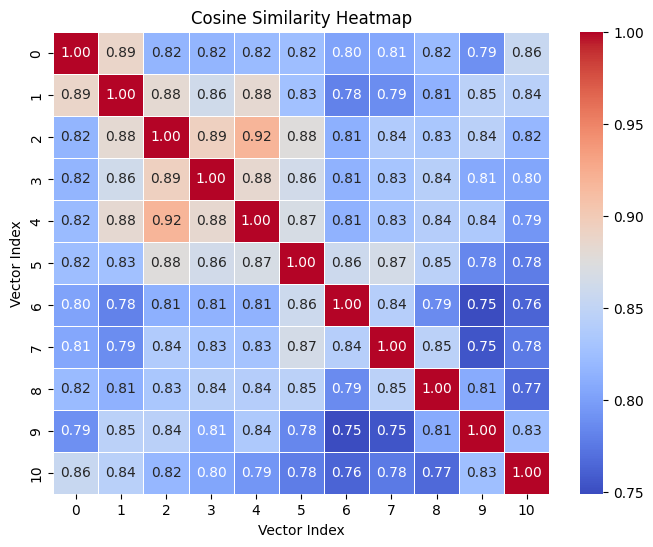

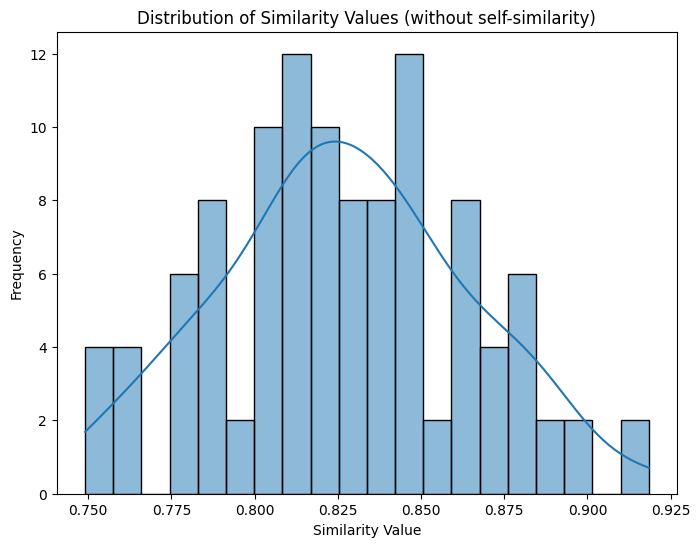

Variance of the similarity matrix (without self-similarity): 0.0013763093277161147


In [38]:
# One-line test
# Fetch data
source = [x for x in list(df.iloc[1])[1:] if x.lower().strip() != "not available"]
vectors = embed_vector(source)

# Convert the list of vectors to a numpy array
vector_array = np.array(vectors)

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(vector_array)

# Print the similarity matrix
# print(similarity_matrix)

# Create a heatmap to visualize the similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Cosine Similarity Heatmap')
plt.xlabel('Vector Index')
plt.ylabel('Vector Index')
plt.show()

def analyze_similarity_matrix_without_self(similarity_matrix, plot = False):
    # Remove self-similarity by setting the diagonal to NaN
    np.fill_diagonal(similarity_matrix, np.nan)
    
    # Calculate the variance of the similarity matrix ignoring NaN values
    variance = np.nanvar(similarity_matrix)
    
    # Flatten the similarity matrix to get the distribution of values, excluding NaN values
    distribution = similarity_matrix.flatten()
    distribution = distribution[~np.isnan(distribution)]
    
    if plot:    
        # Plot the distribution as a histogram
        plt.figure(figsize=(8, 6))
        sns.histplot(distribution, bins=20, kde=True)
        plt.title('Distribution of Similarity Values (without self-similarity)')
        plt.xlabel('Similarity Value')
        plt.ylabel('Frequency')
        plt.show()
    else:
        return variance
    return variance

vector_array = np.array(vectors)
similarity_matrix = cosine_similarity(vector_array)

variance = analyze_similarity_matrix_without_self(similarity_matrix, plot=True)
print(f"Variance of the similarity matrix (without self-similarity): {variance}")


In [39]:
# Iterate and add the variance column to the DF
df["sim_variance"] = [analyze_similarity_matrix_without_self(
    cosine_similarity(
        np.array(
            embed_vector(
                [i for i in list(df.iloc[x]) if i.strip().lower() != "not available"]
                )
            )
        )
    ) for x in range(len(df))]

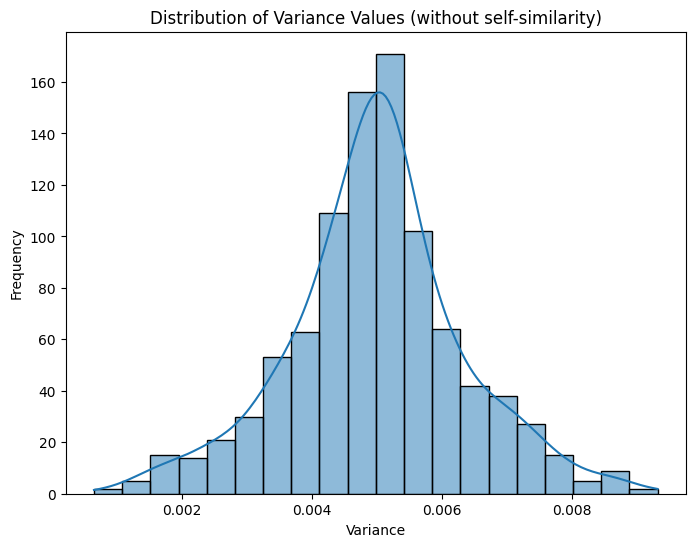

True

In [40]:
plot_variance_distribution(df.sim_variance)

### PCA

In [45]:
import pandas as pd

# Load the CSV data into a DataFrame
df = pd.read_csv("./drugbank_data.csv")

# Example of distinct drug categories
distinct_drug_categories = ["Antibiotic", "Analgesic", "Antidepressant", "Antiviral", "Antifungal"]

# Define the function to determine the best drug category
def best_drug_category(drug_categories, distinct_categories):
    # Check if the input is valid
    if not isinstance(drug_categories, str) or not drug_categories:
        return "Unknown"  # Default category if input is invalid or empty
    # Split the drug categories if they are combined in a single string
    drug_category_list = drug_categories.split(',')
    # Example logic to find the best match (you can customize this logic)
    for category in drug_category_list:
        if category.strip() in distinct_categories:
            return category.strip()
    return "Unknown"  # Default category if no match is found

# Replace NaN values in the 'Drug Categories' column with an empty string
df["Drug Categories"].fillna("", inplace=True)

# Apply the function to each row in the DataFrame
df["one_category"] = df["Drug Categories"].apply(lambda x: best_drug_category(x, distinct_drug_categories))

# Display the DataFrame with the new category column
print(df.head())


  DrugBank ID              Name  \
0     DB01000       Cyclacillin   
1     DB01001         Albuterol   
2     DB01002   Levobupivacaine   
3     DB01003  Cromoglicic acid   
4     DB01004       Ganciclovir   

                                         Description  \
0     A cyclohexylamido analog of penicillanic acid.   
1  Albuterol is a beta-2 adrenergic receptor agon...   
2  Levobupivacaine is a drug used for nerve block...   
3  Cromoglicic acid is a medication used to treat...   
4  Ganciclovir is a DNA polymerase inhibitor used...   

                                 Mechanism of Action  \
0  The bactericidal activity of cyclacillin resul...   
1  In vitro studies and in vivo pharmacologic stu...   
2  Local anesthetics such as Levobupivacaine bloc...   
3  Cromoglicate inhibits degranulation of mast ce...   
4  Ganciclovir's antiviral activity inhibits viru...   

                                          Indication  \
0  For the treatment of bacterial infections caus...   
1  

/var/folders/fq/jhg4d1x54s7djyrxjpq4h4b80000gn/T/ipykernel_12116/1236413944.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Drug Categories"].fillna("", inplace=True)


In [46]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

label_column = "Name"

def chunk_list(lst, chunk_size, token_limit):
    """Yield successive chunks from lst with a limit on chunk size and token count."""
    chunk = []
    total_tokens = 0
    for text in lst:
        token_count = len(text.split())
        if len(chunk) >= chunk_size or (total_tokens + token_count) > token_limit:
            yield chunk
            chunk = []
            total_tokens = 0
        chunk.append(text)
        total_tokens += token_count
    if chunk:
        yield chunk

def transform_text_columns_to_embeddings(data, text_columns, chunk_size=128, token_limit=6000):
    # Concatenate all text columns into a single string for each row
    combined_text = data[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

    combined_text.replace("Not Available", "")
    
    embeddings = []
    
    # Process the text data in chunks to avoid batch size and token limits
    for text_chunk in chunk_list(combined_text.tolist(), chunk_size, token_limit):
        chunk_embeddings = embed_vector(text_chunk)
        embeddings.extend(chunk_embeddings)
    
    return embeddings

# Define the text columns (assuming the text columns are all except 'DrugBank ID')
text_columns = df.columns.drop('DrugBank ID')

# Transform the text columns into vector embeddings
embeddings = transform_text_columns_to_embeddings(df, text_columns)

# Extract the labels
labels = df[label_column]
categories = df["one_category"]

def perform_pca(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    return pca_result

# Perform PCA to reduce the dimensionality to 2 components
pca_result = perform_pca(embeddings)

In [47]:
pca_data = pd.DataFrame({
        'Principal Component 1': pca_result[:, 0],
        'Principal Component 2': pca_result[:, 1],
        'Label': labels,
        'Category': categories
    })

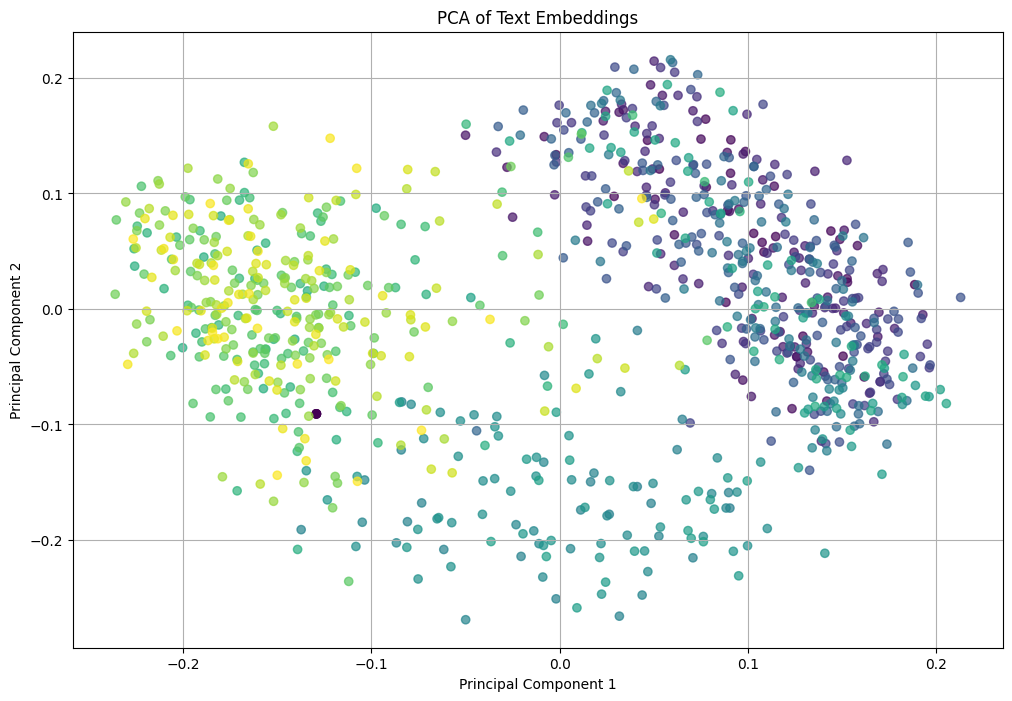

In [48]:
# Plot PCA results with Matplotlib and mplcursors
def plot_pca_result_with_labels(pca_result, labels):
    df = pd.DataFrame({
        'Principal Component 1': pca_result[:, 0],
        'Principal Component 2': pca_result[:, 1],
        'Label': labels
    })
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        df['Principal Component 1'], df['Principal Component 2'],
        c=pd.factorize(df['Label'])[0], cmap='viridis', alpha=0.7
    )
    
    plt.title('PCA of Text Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

plot_pca_result_with_labels(pca_result, labels)

**SAVE SEPARATELY TO TEXT FILES**

In [49]:
import pandas as pd
import os

# Directory to save text files
output_dir = './data/drugbank/'
os.makedirs(output_dir, exist_ok=True)

# Function to save each row as a text file
def save_row_as_text(row, output_dir):
    if row["DrugBank ID"] != "N/A":
        file_name = f"{row['DrugBank ID']}.txt"
        file_path = os.path.join(output_dir, file_name)
        with open(file_path, 'w') as file:
            for column, value in row.items():
                file.write(f"{column}: {value}\n")

# Save each row in the dataframe as a text file
df.apply(lambda row: save_row_as_text(row, output_dir), axis=1)

# List the created files to verify
os.listdir(output_dir)

['DB01937.txt',
 'DB01089.txt',
 'DB01923.txt',
 'DB01738.txt',
 'DB01710.txt',
 'DB01076.txt',
 'DB01062.txt',
 'DB01704.txt',
 'DB01248.txt',
 'DB01274.txt',
 'DB01512.txt',
 'DB01506.txt',
 'DB01260.txt',
 'DB01499.txt',
 'DB02153.txt',
 'DB01328.txt',
 'DB01466.txt',
 'DB01472.txt',
 'DB01843.txt',
 'DB01857.txt',
 'DB01880.txt',
 'DB01658.txt',
 'DB01664.txt',
 'DB01102.txt',
 'DB01116.txt',
 'DB01670.txt',
 'DB01117.txt',
 'DB01671.txt',
 'DB01665.txt',
 'DB01103.txt',
 'DB01895.txt',
 'DB01659.txt',
 'DB01881.txt',
 'DB01856.txt',
 'DB01842.txt',
 'DB01473.txt',
 'DB01301.txt',
 'DB01467.txt',
 'DB01329.txt',
 'DB01498.txt',
 'DB01261.txt',
 'DB01275.txt',
 'DB01513.txt',
 'DB00157.txt',
 'DB01249.txt',
 'DB01063.txt',
 'DB01705.txt',
 'DB01711.txt',
 'DB01077.txt',
 'DB01739.txt',
 'DB01922.txt',
 'DB01936.txt',
 'DB01088.txt',
 'DB01920.txt',
 'DB01934.txt',
 'DB04864.txt',
 'DB01908.txt',
 'DB01049.txt',
 'DB01707.txt',
 'DB01061.txt',
 'DB01075.txt',
 'DB01713.txt',
 'DB0128